# Visual EDA

The [first page of this chapter](04b-whyplot) discussed the reasons we plot our data. 
1. Data cleaning: To find issues in the data that need to get fixed before we can do larger analysis
2. Data exploration: Learning about each of the variables, how they covary, and what further questions you can ask of the data
3. Analysis and presentation

## EDA on a classic firm financial dataset

In [the Pandas EDA](02e_eda_golden) page, I explored Compustat by producing summary stats to get a sense of the variables involved, look for missing values, and look for problematic outliers. We noted that some variables, like $delaycon$, had a lot of missing values and decided we'd look into it. 

Let's continue exploring that dataset. First, let's download our slice of it. The variables are listed and described in a csv file in the [repo's data folder.](https://github.com/LeDataSciFi/ledatascifi-2021/tree/main/data) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# these three are used to download the file
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

url = 'https://github.com/LeDataSciFi/ledatascifi-2021/blob/main/data/CCM_cleaned_for_class.zip?raw=true'

#firms = pd.read_stata(url)   
# <-- that code would work, but GH said it was too big and
# forced me to zip it, so here is the work around to download it:

with urlopen(url) as request:
    data = BytesIO(request.read())

with ZipFile(data) as archive:
    with archive.open(archive.namelist()[0]) as stata:
        ccm = pd.read_stata(stata)


## The mystery of the poorly populated variables

Again, there are some variables with lots of missing values.

In [2]:
(
    ( # these lines do the calculation - what % of missing values are there for each var
        ccm.isna()      # ccm.isna() TURNS every obs/variable = 1 when its missing and 0 else
       .sum(axis=0)     # count the number of na for each variable (now data is 1 obs per column = # missing)
        /len(ccm)       # convert # missing to % missing 
        *100            # report as percentage
    ) 
    # you can stop here and report this...
    # but I wanted to format it a bit...
    .sort_values(ascending=False)[:13]
    .to_frame(name='% missing') # the next line only works on a frame, and because pandas sees only 1 variable at this pt
    .style.format("{:.1f}")     # in the code, it calls this a "series" type object, so convert it to dataframe type object
)
#

,% missing
privdelaycon,74.4
debtdelaycon,74.4
equitydelaycon,74.4
delaycon,74.4
prodmktfluid,60.4
tnic3tsimm,56.5
tnic3hhi,56.5
largetaxlosscarry,33.5
smalltaxlosscarry,33.5
invopps_FG09,13.0


When variables missing that much in a dataset, something systematic is going on and you need to figure it out. 

One way you could investigate why those variables are missing. Maybe it's a data issue, as if some data for variable $x$ isn't available in all years. E.g. perhaps a variable isn't available before 1995 for some reason.

A way you could get a start on that is to plot the % missing by year for each variable. This legend is UGGGGLY, because the plot has 40+ series, which is why it's a **spaghetti chart**. It would take extra work to unravel the spaghetti and figure out what variables are what. But CLEARLY some variables only become available in 1995 so they can be used after that.

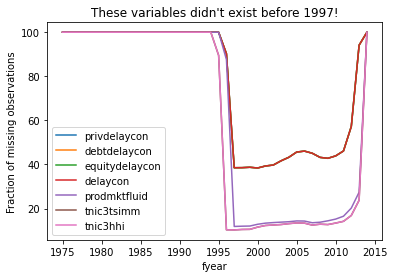

In [3]:
(
ccm
    .groupby('fyear')
    [['privdelaycon','debtdelaycon','equitydelaycon','delaycon',
     'prodmktfluid','tnic3tsimm','tnic3hhi']]
    .apply(lambda x: 100*(x.isna().sum(axis=0))  / len(x) ) 
    .plot.line(title="These variables didn't exist before 1997!",
               ylabel="Fraction of missing observations")
)
plt.show()

## Explorating covariances/relationships between variables

To get a quick sense of relationships, I like to use I like to use `pairplot` and `heatmap` to get a quick since of relationships.

### Getting the big picture with [**Pairplot**](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

I like passing `corner=True` or using the `x_vars` and `y_vars` parameters to make the info shown more usable. 

```{warning}
With pairplot, 
1. Use 7 or fewer variables at a time. If your dataset has a lot of variables, do them part by part.
2. Don't plot all of the data points! This will oversaturate your graphs and make it harder to draw any conclusions. Below, I randomly sample a piece of the dataset. 
```

**It's clear from running these two plots that some extreme outliers are hiding patterns by messing with the scales and influencing the regression lines.**

(We should deal with these outliers later.)

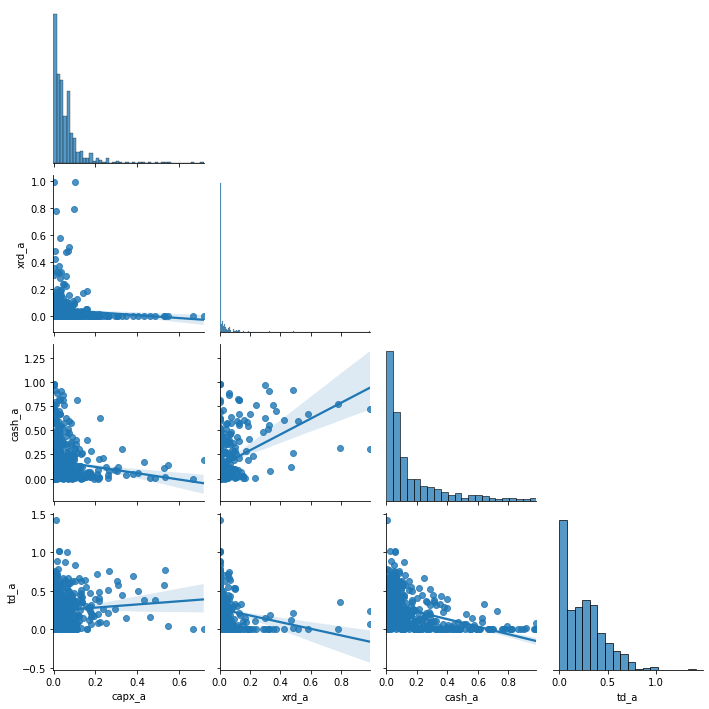

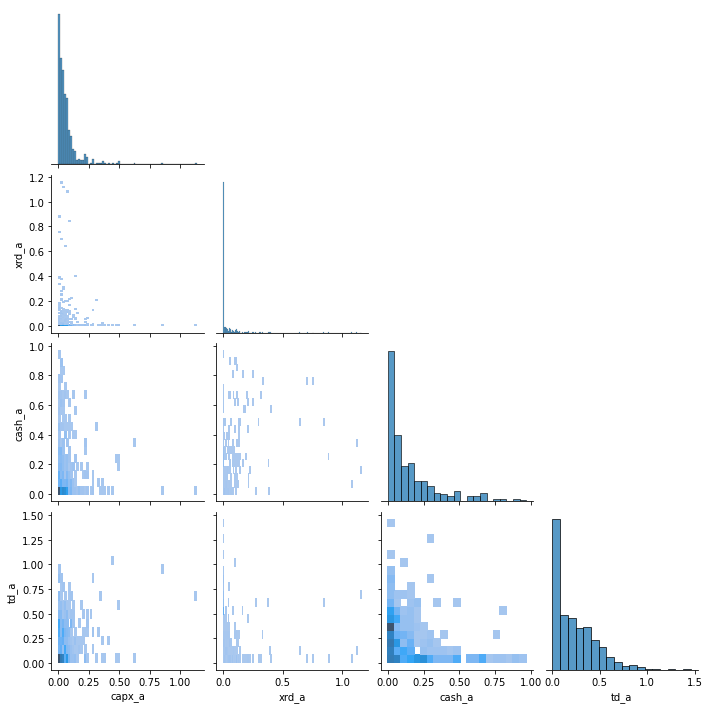

In [4]:
# every time you run this, you'll get diff figures... why?!
f1 = sns.pairplot(ccm[['capx_a', 'xrd_a', 'cash_a','td_a']].sample(500),
                kind='reg',
                 corner=True)
f2 = sns.pairplot(ccm[['capx_a', 'xrd_a', 'cash_a','td_a']].sample(500),
                kind='hist',
                 corner=True) # hist handles a lot of datapoints well


### Getting the big picture with [**Heatmap with correlations**](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

After some pairplots (and often before), I like to look at correlations.

```{warning}
This analysis step doesn't help for categorical variables!

Make sure you don't include categorical variables that are numbers!

(E.g. industry classifications are numbers that have no meaning.)
```

Seeing the correlations between variables is nice.

A correlation table is ugly and hard to work with:


In [5]:
ccm.corr()

,gvkey,fyear,lpermno,sic,sic3,age,at,me,l_a,l_sale,...,tnic3hhi,tnic3tsimm,prodmktfluid,delaycon,equitydelaycon,debtdelaycon,privdelaycon,l_emp,l_ppent,l_laborratio
gvkey,1.000000,0.534930,0.475523,0.107321,0.107265,-0.276126,0.010126,0.014763,0.126591,0.038674,...,-0.021473,0.036015,0.244347,0.212391,0.225956,-0.110047,0.276941,-0.090190,0.002419,0.103596
fyear,0.534930,1.000000,0.402615,0.098469,0.098408,0.449878,0.080264,0.142570,0.345151,0.243784,...,0.047983,-0.084418,0.060319,-0.028163,-0.037806,0.029978,-0.048051,0.029245,0.184322,0.257928
lpermno,0.475523,0.402615,1.000000,0.110724,0.110660,-0.195393,0.019407,-0.021205,0.029452,-0.042433,...,-0.019426,0.049461,0.168210,0.132109,0.150432,-0.039851,0.188820,-0.155718,-0.079054,0.054108
sic,0.107321,0.098469,0.110724,1.000000,0.999999,-0.072601,0.036937,-0.016392,0.050434,-0.031385,...,-0.052579,0.138981,0.111862,-0.034781,-0.025027,-0.067122,0.046615,-0.030025,-0.152852,-0.223692
sic3,0.107265,0.098408,0.110660,0.999999,1.000000,-0.072562,0.036988,-0.016361,0.050608,-0.031159,...,-0.052559,0.138958,0.111700,-0.034839,-0.025132,-0.066992,0.046468,-0.029792,-0.152593,-0.223594
age,-0.276126,0.449878,-0.195393,-0.072601,-0.072562,1.000000,0.079051,0.191595,0.376925,0.394578,...,0.052359,-0.154524,-0.243894,-0.210383,-0.239992,0.108078,-0.296800,0.304658,0.366293,0.187915
at,0.010126,0.080264,0.019407,0.036937,0.036988,0.079051,1.000000,0.418377,0.250631,0.192991,...,-0.034427,0.026975,0.060690,0.004913,-0.004631,0.014204,-0.031252,0.221481,0.174699,0.058018
me,0.014763,0.142570,-0.021205,-0.016392,-0.016361,0.191595,0.418377,1.000000,0.359011,0.338825,...,-0.027534,-0.029282,0.013475,-0.005837,-0.010836,-0.018789,-0.018693,0.391248,0.349469,0.142494
l_a,0.126591,0.345151,0.029452,0.050434,0.050608,0.376925,0.250631,0.359011,1.000000,0.872928,...,-0.244952,0.135873,0.070614,-0.065039,-0.139895,0.171411,-0.221926,0.718865,0.832030,0.373117
l_sale,0.038674,0.243784,-0.042433,-0.031385,-0.031159,0.394578,0.192991,0.338825,0.872928,1.000000,...,-0.108592,-0.162672,-0.164440,-0.174759,-0.276642,0.242195,-0.359774,0.805165,0.832674,0.196937


But a lazily made figure of that exact same info is somewhat workable:

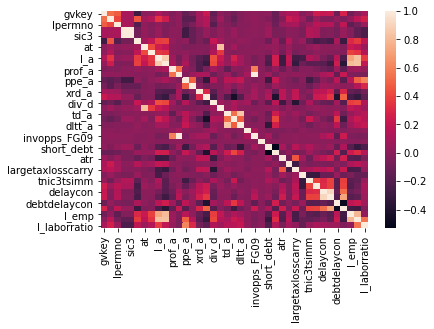

In [6]:
f3 = sns.heatmap(ccm.corr()) # v1, use the nicer version below!

Cleaning that and making it more useful is easy:
1. Drop the numerical variables that don't make sense in a correlation matrix
2. Make the figure large enough to see
3. Colors: cold for negative corr, hot for positive corr

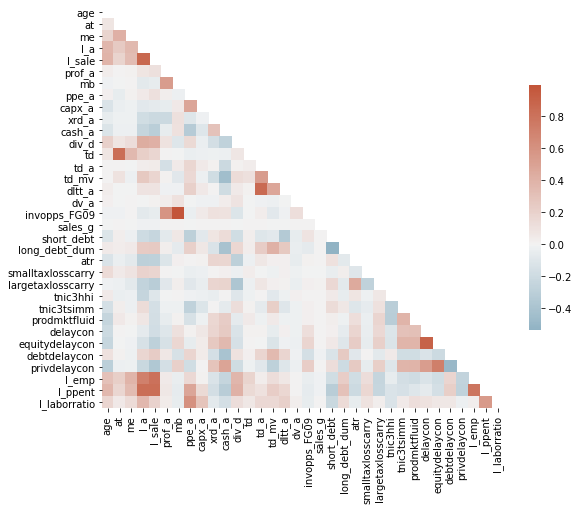

In [7]:
# dont plot identifying type info or categorical vars
corr = ccm.drop(columns=['gvkey','lpermno','sic3','fyear','sic']).corr()

fig, ax = plt.subplots(figsize=(9,9)) # make a big space for the figure
ax = sns.heatmap(corr,
                 # cmap for the colors, 
                 center=0,square=True,
                 cmap=sns.diverging_palette(230, 20, as_cmap=True),
                 # mask to hide the upper diag (redundant)
                 mask=np.triu(np.ones_like(corr, dtype=bool)),
                 # shrink the heat legend
                 cbar_kws={"shrink": .5},
                 #optional: vmax and vmin will "cap" the color range
                )

That is an information DENSE figure, but we somehow managed to get it on screen decently! Still, it's a ton of variables, and doing this in parts would be a good idea.

```{tip}
If you're feeling frisky, and your data is in good shape, you can push this farther by using [`sns.clustermap`](https://seaborn.pydata.org/generated/seaborn.clustermap.html) to find clusters of similar variables. 
```

Also - don't take these correlations as gospel yet: They should *point* you towards further relationships to explore, which you should do one plot at a time.

### Digging in with [**lmplot**](https://seaborn.pydata.org/generated/seaborn.relplot.html) and [**Jointplot**](https://seaborn.pydata.org/generated/seaborn.jointplot.html)

These are good for digging into the relationships between two continuous variables. 

Let's dig into a strong correlation suggested by our heatmap.

```{warning}

Jointplot can be slow - it's doing a lot. 

Again, don't plot all of the data points! As your sample size goes up, either randomly sample data, or use "hex" style graphs. 
```

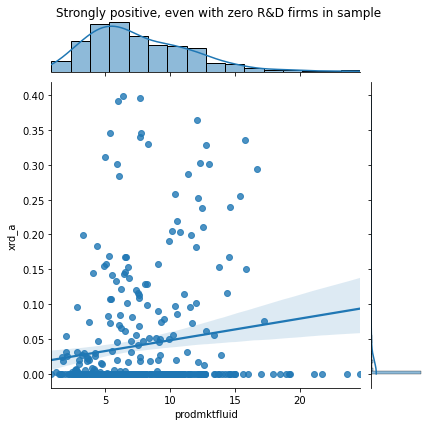

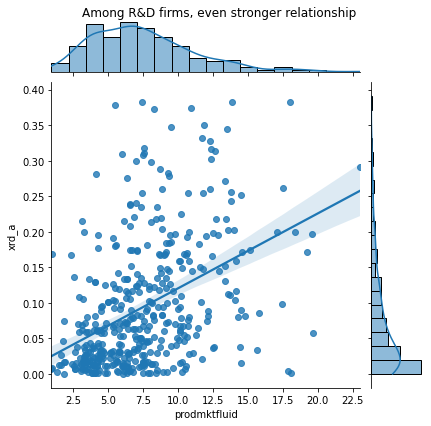

In [17]:
f1 = sns.jointplot(data=ccm.query('xrd_a<.4').sample(1000),
                  x="prodmktfluid", y="xrd_a", kind='reg') 
# notice: most firms have 0 R&D!
f2 = sns.jointplot(data=ccm.query('xrd_a<.4 & xrd_a > 0').sample(1000),
                  x="prodmktfluid", y="xrd_a", kind='reg')

# set_title doesn't work with jointplots
f1.fig.suptitle('Strongly positive, even with zero R&D firms in sample')
f1.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
f2.fig.suptitle('Among R&D firms, even stronger relationship')
f2.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


I'd pencil this as a relationship to look into more (Do firms do more R&D _**because**_ of the fluidity of their product market?) and then continue exploring. 

`lmplot` will plot regressions as well, but it makes it easy add facets to see if the relationship depends on a third (categorical) variable with the `hue`, `col`, and `row` parameters. (And you can combine `hue`, `col`, and `row` to see several cuts!)

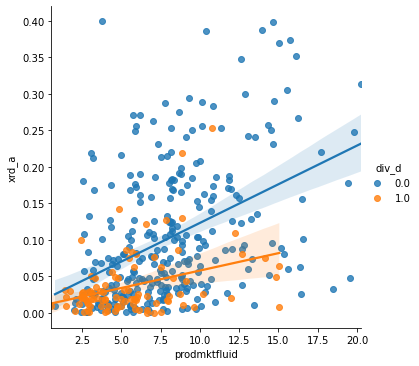

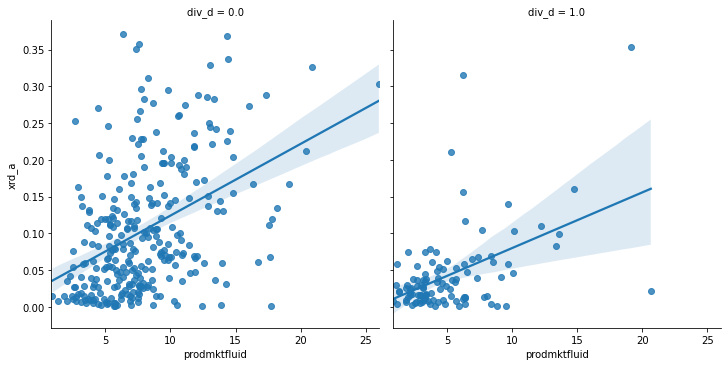

In [18]:
f3 = sns.lmplot(data=ccm.query('xrd_a<.4 & xrd_a > 0').sample(1000),
                  x="prodmktfluid", y="xrd_a", hue='div_d')
f4 = sns.lmplot(data=ccm.query('xrd_a<.4 & xrd_a > 0').sample(1000),
                  x="prodmktfluid", y="xrd_a", col='div_d')
